In [17]:
import json
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pylab
import random
from skimage import transform
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap
random.seed(1)

In [3]:
# load data and visualize q and bbox
region_desc_name = '../data/data/datasets/vg/region_descriptions.json'
img_path = '../data/data/datasets/vg/'
vg_boxes_name = '../data/data/datasets/vg/vg_boxes.npy'

region_desc_data = json.load(open(region_desc_name))
vg_boxes_data = np.load(vg_boxes_name, allow_pickle=True)

In [13]:
region_desc_data[0]
imgid_region_map = {i['id']:i['regions'] for i in region_desc_data}

In [6]:
vg_boxes_data[0]

{'image_path': 'VG_100K_2/1.jpg',
 'image_width': 800,
 'image_height': 600,
 'image_id': '1',
 'normalized_boxes': array([[0.52625   , 0.095     , 0.62875   , 0.32666665],
        [0.2425    , 0.62      , 0.47      , 0.8016667 ],
        [0.30125   , 0.8183333 , 0.3775    , 0.86833334],
        ...,
        [0.315     , 0.00166667, 0.9775    , 0.9316667 ],
        [0.10125   , 0.525     , 0.9875    , 0.99333334],
        [0.495     , 0.01      , 0.99      , 0.49833333]], dtype=float32)}

In [82]:
def display_img(pred_im_path, ocr_results, notes='vg'):
    im = cv2.imread(pred_im_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im)

    for res in ocr_results:
        bbox = res['bbox']
        txt = res['txt']
        plt.gca().add_patch(
            plt.Rectangle((bbox[0][0], bbox[0][1]),
                          bbox[1][0] - bbox[0][0],
                          bbox[1][1] - bbox[0][1], fill=False,
                          edgecolor='red', linewidth=2, alpha=0.5)
                )
        plt.gca().text(bbox[0][0], bbox[0][1] - 5,
                    '%s' % (txt),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=15, color='white')
    plt.gca().text(20,50, notes,
                    bbox=dict(facecolor='blue', alpha=0.9),
                    fontsize=30, color='white')

    
def post_process_results(results):
    outputs = [] # a list of dicts with keys "bbox","txt" 
    for res in results:
        output = {'txt':res['phrase'], 'bbox':[[res['x'], res['y']], 
                                               [res['x']+res['width'], res['y']+res['height']]]}
        outputs.append(output)

    return outputs

def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
#     scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
#     order = scores.argsort()[::-1]
    order = np.array(range(len(dets)))
    keep = []
    while len(order) > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [83]:
# randomly sample an image from vg_boxes_data
box_info = random.choice(vg_boxes_data)
region_info = imgid_region_map[int(box_info['image_id'])]
region_info = post_process_results(region_info)

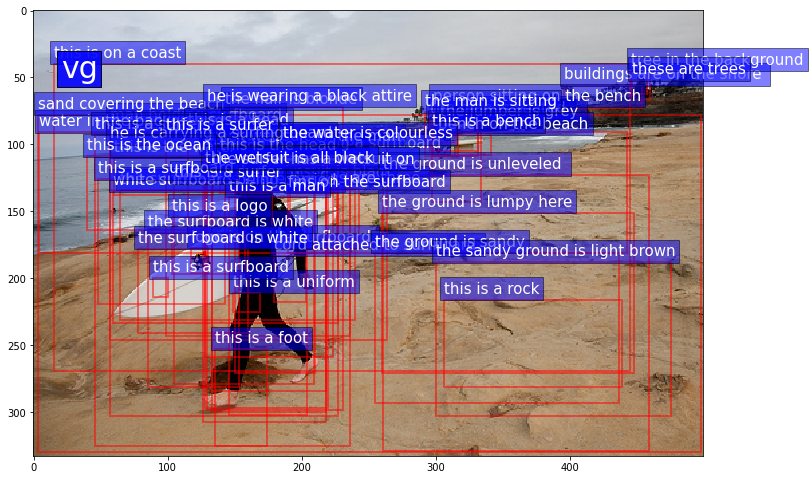

In [85]:
display_img(os.path.join(img_path, box_info['image_path']), region_info)

In [89]:
# try nms
# convert to x1y1x2y2
all_regions = np.array([[i['bbox'][0][0],i['bbox'][0][1],i['bbox'][1][0],i['bbox'][1][1]] for i in region_info])
# apply nms
regions_needed = nms(all_regions, thresh=0.1)
region_info = [r for i, r in enumerate(region_info) if i in regions_needed]


{'image_path': 'VG_100K/2318536.jpg', 'image_width': 500, 'image_height': 333, 'image_id': '2318536', 'normalized_boxes': array([[0.3       , 0.3873874 , 0.42      , 0.8138138 ],
       [0.266     , 0.3183183 , 0.436     , 0.9009009 ],
       [0.252     , 0.3213213 , 0.436     , 0.9219219 ],
       [0.128     , 0.4024024 , 0.48      , 0.6936937 ],
       [0.382     , 0.3993994 , 0.486     , 0.5345345 ],
       [0.592     , 0.24324325, 0.664     , 0.3153153 ],
       [0.792     , 0.16816817, 0.908     , 0.21921922],
       [0.234     , 0.5315315 , 0.26      , 0.5885886 ],
       [0.606     , 0.24924925, 0.63      , 0.2972973 ],
       [0.522     , 0.36936936, 0.918     , 0.987988  ],
       [0.114     , 0.25825825, 0.454     , 0.9099099 ],
       [0.118     , 0.4054054 , 0.454     , 0.6996997 ],
       [0.604     , 0.2792793 , 0.682     , 0.3243243 ],
       [0.596     , 0.21621622, 0.634     , 0.32732734],
       [0.256     , 0.3063063 , 0.44      , 0.8918919 ],
       [0.008     , 0.2

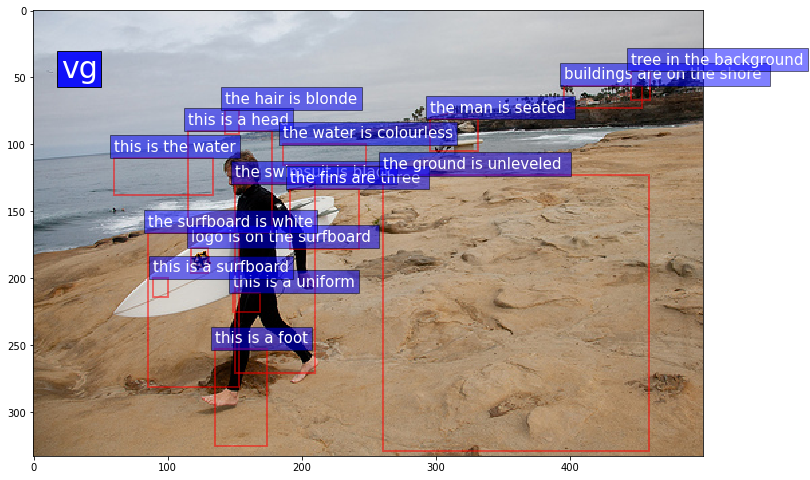

In [91]:
display_img(os.path.join(img_path, box_info['image_path']), region_info)
print(box_info)
print(region_info)